In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import pandas as pd
from preprocessing import load_if_in_country_or_lang
from preprocessing import categorize_views_for_df
from processing import filter_by_region_cat_code, build_regression_dataframe, load_preprocessed_events
import numpy as np

In [382]:
df_crawled.head()

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Year,GDP_pc,GDP,oecd,date_month,views_baseline,in_code_lang,in_code_region,views_baseline_cat,view_country_article
0,Q100021,Pakistan International Airlines Flight 661,2016-12-07,Global South,Pakistan,Asia,disaster,"['Category:2016 disasters in Pakistan', 'Categ...",248274,0.000000,...,2016,1362.860008,2.775210e+11,False,2016-12-01,8.684000e+07,True,False,>10^7,13615.0
1,Q100231328,Gretchen Whitmer kidnapping plot,2020-10-08,Global North,United States,North America,disaster,"['Category:2020 crimes in the United States', ...",74144,0.000000,...,2020,63122.594145,2.089375e+13,True,2020-10-01,3.137752e+09,True,True,>10^9,48675.0
2,Q100256872,Killing of Babu Lal Vaishnav,2020-10-08,Global South,India,Asia,disaster,"['Category:2020 crimes in India', 'Category:20...",427,0.000000,...,2020,1930.971218,2.664749e+12,False,2020-10-01,7.142770e+08,True,False,>10^8,34273.0
3,Q100279235,Miss Vietnam 2020,2020-11-20,Global South,Vietnam,Asia,culture,"['Category:2020 beauty pageants', 'Category:Be...",1444,49.285714,...,2020,2785.724225,2.711584e+11,False,2020-11-01,1.619000e+07,False,False,>10^7,8731.0
4,Q100288161,2020 Ganja missile attacks,2020-10-11,Global South,Azerbaijan,Asia,disaster,"['Category:2020 in Azerbaijan', 'Category:Arti...",7410,0.000000,...,2020,4202.232239,4.260718e+10,False,2020-10-01,3.088000e+06,False,False,>10^6,6148.0


In [5]:
df_crawled = load_preprocessed_events()
df_crawled = load_if_in_country_or_lang(df_crawled)
df_crawled = categorize_views_for_df(df_crawled)
df_crawled.event_date = pd.to_datetime(df_crawled.event_date)
df_crawled.head()

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Country/Area,Year,GDP_pc,GDP,oecd,date_month,views_baseline,in_code_lang,in_code_region,views_baseline_cat
0,Q100021,Pakistan International Airlines Flight 661,2016-12-07,Global South,Pakistan,Asia,disaster,"['Category:2016 disasters in Pakistan', 'Categ...",248274,0.000000,...,Pakistan,2016,1362.860008,2.775210e+11,False,2016-12-01,8.684000e+07,True,False,>10^7
1,Q100231328,Gretchen Whitmer kidnapping plot,2020-10-08,Global North,United States,North America,disaster,"['Category:2020 crimes in the United States', ...",74144,0.000000,...,United States,2020,63122.594145,2.089375e+13,True,2020-10-01,3.137752e+09,True,True,>10^9
2,Q100256872,Killing of Babu Lal Vaishnav,2020-10-08,Global South,India,Asia,disaster,"['Category:2020 crimes in India', 'Category:20...",427,0.000000,...,India,2020,1930.971218,2.664749e+12,False,2020-10-01,7.142770e+08,True,False,>10^8
3,Q100279235,Miss Vietnam 2020,2020-11-20,Global South,Vietnam,Asia,culture,"['Category:2020 beauty pageants', 'Category:Be...",1444,49.285714,...,Vietnam,2020,2785.724225,2.711584e+11,False,2020-11-01,1.619000e+07,False,False,>10^7
4,Q100288161,2020 Ganja missile attacks,2020-10-11,Global South,Azerbaijan,Asia,disaster,"['Category:2020 in Azerbaijan', 'Category:Arti...",7410,0.000000,...,Azerbaijan,2020,4202.232239,4.260718e+10,False,2020-10-01,3.088000e+06,False,False,>10^6


In [ ]:
from preprocessing import replace_country_names
df_pageviews_all = pd.read_csv(f'countries/pageviews_countries.csv')
df_pageviews_all.date = pd.to_datetime(df_pageviews_all.date)
df_pageviews_all['month_year'] = df_pageviews_all.apply(lambda row: f'{row.date.year}-{row.date.month:02d}', axis=1)
df_pageviews_all['date_month'] = df_pageviews_all.apply(lambda row: pd.to_datetime(f'{row.month_year}-01'), axis=1)
replace_country_names(df_pageviews_all, inplace=True)
df_pageviews_all = df_pageviews_all.rename({view_col: view_col.replace('views_', '') for view_col in df_pageviews_all.columns if view_col.startswith('views_')}, axis=1)

In [36]:
from dateutil.relativedelta import relativedelta
def get_pageviews_baseline(row, df_pageviews, ts_months, pre_period = 7, func=np.median):
    return np.median(df_pageviews[(df_pageviews.en_article == row.country) & (df_pageviews.date >= (row.event_date - relativedelta(months=ts_months, days=pre_period))) & (df_pageviews.date < (row.event_date - relativedelta(days=pre_period)))][row.code])

df_crawled['view_country_article'] = df_crawled.apply(lambda row: get_pageviews_baseline(row, df_pageviews_all, 5), axis=1)

# Regression

In [ ]:
from regression import fit_nb_with_estimated_alpha, estimate_alpha, fit_nb, standardize_var, fit_nb_with_estimated_alpha_all_codes

In [471]:
df_filtered = df_crawled[(df_crawled.cat != 'undefined') & (df_crawled.views_7_sum > 10)].copy()
df_filtered['gdp_pc_z'] = standardize_var(df_filtered, 'GDP_pc')
df_filtered['gdp_z'] = standardize_var(df_filtered, 'GDP')
df_filtered['pop_z'] = standardize_var(df_filtered, 'population')
df_filtered['views_baseline_z'] = standardize_var(df_filtered, 'views_baseline')
df_filtered['view_country_article_z'] = standardize_var(df_filtered, 'view_country_article')
df_filtered['bing_hits_z'] = standardize_var(df_filtered, 'bing_hits')
df_filtered['worldwide'] = df_filtered.code.apply(lambda c: (c == 'en') or (c=='es'))

In [476]:
nb_fit_dict = fit_nb_with_estimated_alpha_all_codes(['en', 'es', 'de', 'it'], df_filtered, 'views_7_sum ~ np.log1p(view_country_article) + np.log1p(views_baseline) + np.log1p(GDP_pc) + cat * economic_region', est_method='lbfgs')

for key, vals in nb_fit_dict.items():
    display(f'---------------- Summary for {key} ----------------')
    display(vals.summary())
    #print(vals.mle_retvals)

 ================= Fitting en =================
Estimated alpha as 14.940744892816612 (p=0.00012691725306431082)
Deviance: 2010.1957546306587|Null-deviance: 2170.8507425076805|Chi-sq ("good fit"): 7798.855100752451
Pseudo R² (1 - D/D_0) = 0.07400554295660122
H0: Model provides adequate fit for data: p=1.0
Overdispersion factor:  1.100666596743826
 ================= Fitting es =================
Estimated alpha as 17.152721661797077 (p=0.0003590065671479548)
Deviance: 722.7066375781529|Null-deviance: 799.019316004074|Chi-sq ("good fit"): 3320.468491979389
Pseudo R² (1 - D/D_0) = 0.09550792690164689
H0: Model provides adequate fit for data: p=1.0
Overdispersion factor:  1.2618852010766621
 ================= Fitting de =================
Estimated alpha as 5.206448082565186 (p=0.11992806166560796)
Deviance: 1493.2530368651755|Null-deviance: 1829.1733006340432|Chi-sq ("good fit"): 2119.5177487008445
Pseudo R² (1 - D/D_0) = 0.183645947408279
H0: Model provides adequate fit for data: p=1.0
Ove

'---------------- Summary for en ----------------'

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                 7606
Model:                            GLM   Df Residuals:                     7595
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                         lbfgs   Log-Likelihood:                -87679.
Date:                Tue, 05 Apr 2022   Deviance:                       2010.2
Time:                        14:50:43   Pearson chi2:                 8.36e+03
No. Iterations:                    62                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                           5.5035      0.948      5.807      0.000       3.646       7.361
cat[T.disaster]                                     1.1014      0.252      4.376      0.000       0.608       1.595
cat[T.politics]                                     0.1935      0.193      1.005      0.315      -0.184       0.571
cat[T.sports]                                      -0.1768      0.182     -0.969      0.332      -0.534       0.181
economic_region[T.Global South]                    -0.4491      0.440     -1.022      0.307      -1.311       0.413
cat[T.disaster]:economic_region[T.Global South]     0.3176      0.493      0.644      0.520      -0.649       1.284
cat[T.politics]:economic_region[T.Global South]     0.6370      0.458      1.390      0.165      -0.261       1.535
cat[T.sports]:economic_region[T.Global South]       0.9176      0.435      2.110      0.035       0.065       1.770
np.log1p(view_country_article)                      0.4590      0.124      3.701      0.000       0.216       0.702
np.log1p(views_baseline)                            0.0671      0.042      1.584      0.113      -0.016       0.150
np.log1p(GDP_pc)                                   -0.0879      0.076     -1.156      0.248      -0.237       0.061
===================================================================================================================
"""

'---------------- Summary for es ----------------'

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                 3199
Model:                            GLM   Df Residuals:                     3188
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                         lbfgs   Log-Likelihood:                -32185.
Date:                Tue, 05 Apr 2022   Deviance:                       722.71
Time:                        14:50:43   Pearson chi2:                 4.02e+03
No. Iterations:                   285                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                           5.4994      1.510      3.641      0.000       2.539       8.460
cat[T.disaster]                                     0.3705      0.489      0.758      0.449      -0.588       1.329
cat[T.politics]                                     0.7975      0.419      1.905      0.057      -0.023       1.618
cat[T.sports]                                      -0.2130      0.377     -0.566      0.572      -0.951       0.525
economic_region[T.Global South]                     0.3103      0.666      0.466      0.641      -0.995       1.616
cat[T.disaster]:economic_region[T.Global South]    -0.2644      0.766     -0.345      0.730      -1.767       1.238
cat[T.politics]:economic_region[T.Global South]    -0.0695      0.697     -0.100      0.921      -1.436       1.297
cat[T.sports]:economic_region[T.Global South]       0.2854      0.652      0.438      0.662      -0.993       1.563
np.log1p(view_country_article)                      0.6131      0.128      4.781      0.000       0.362       0.864
np.log1p(views_baseline)                           -0.0271      0.047     -0.574      0.566      -0.120       0.065
np.log1p(GDP_pc)                                   -0.1527      0.128     -1.194      0.232      -0.403       0.098
===================================================================================================================
"""

'---------------- Summary for de ----------------'

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                 2025
Model:                            GLM   Df Residuals:                     2014
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                         lbfgs   Log-Likelihood:                -19305.
Date:                Tue, 05 Apr 2022   Deviance:                       1493.3
Time:                        14:50:43   Pearson chi2:                 1.12e+04
No. Iterations:                    52                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                           8.6965      1.007      8.632      0.000       6.722      10.671
cat[T.disaster]                                     0.3881      0.292      1.329      0.184      -0.184       0.960
cat[T.politics]                                     0.6845      0.264      2.591      0.010       0.167       1.202
cat[T.sports]                                      -1.2637      0.239     -5.288      0.000      -1.732      -0.795
economic_region[T.Global South]                    -3.2848      1.163     -2.823      0.005      -5.565      -1.005
cat[T.disaster]:economic_region[T.Global South]     3.0073      1.185      2.538      0.011       0.685       5.330
cat[T.politics]:economic_region[T.Global South]     1.6296      1.168      1.395      0.163      -0.659       3.919
cat[T.sports]:economic_region[T.Global South]       3.2124      1.154      2.783      0.005       0.950       5.475
np.log1p(view_country_article)                      0.0873      0.074      1.179      0.239      -0.058       0.232
np.log1p(views_baseline)                            0.0524      0.034      1.543      0.123      -0.014       0.119
np.log1p(GDP_pc)                                   -0.0362      0.079     -0.460      0.645      -0.190       0.118
===================================================================================================================
"""

'---------------- Summary for it ----------------'

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                 1971
Model:                            GLM   Df Residuals:                     1960
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                         lbfgs   Log-Likelihood:                -17973.
Date:                Tue, 05 Apr 2022   Deviance:                       924.18
Time:                        14:50:43   Pearson chi2:                 4.61e+03
No. Iterations:                   201                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                           9.0880      1.411      6.440      0.000       6.322      11.854
cat[T.disaster]                                    -1.1827      0.462     -2.562      0.010      -2.087      -0.278
cat[T.politics]                                    -0.1561      0.341     -0.458      0.647      -0.824       0.512
cat[T.sports]                                      -1.9658      0.279     -7.048      0.000      -2.512      -1.419
economic_region[T.Global South]                    -5.5210      1.150     -4.801      0.000      -7.775      -3.267
cat[T.disaster]:economic_region[T.Global South]     4.5492      1.271      3.579      0.000       2.058       7.040
cat[T.politics]:economic_region[T.Global South]     2.1227      1.192      1.780      0.075      -0.214       4.459
cat[T.sports]:economic_region[T.Global South]       5.1758      1.128      4.589      0.000       2.965       7.386
np.log1p(view_country_article)                      0.4330      0.121      3.593      0.000       0.197       0.669
np.log1p(views_baseline)                           -0.0953      0.051     -1.877      0.060      -0.195       0.004
np.log1p(GDP_pc)                                   -0.0744      0.122     -0.608      0.543      -0.314       0.165
===================================================================================================================
"""

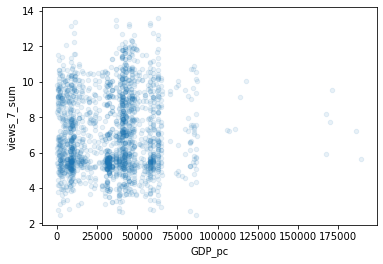

In [299]:
df_inv = df_rel.copy()
df_inv.views_7_sum = np.log1p(df_inv.views_7_sum)
df_inv['gdp_pc_log'] = np.log1p(df_inv.GDP_pc)
df_inv.sort_values('GDP_pc').plot(x='GDP_pc', y='views_7_sum', kind='scatter', alpha=0.1)

In [460]:
nb_fitall = fit_nb_with_estimated_alpha(df_filtered, 'views_7_sum ~ (np.log1p(view_country_article) + np.log1p(views_baseline) + gdp_pc_z) * code', est_method='lbfgs')
#print(nb_fitall.mle_retvals)
nb_fitall.summary()

Estimated alpha as 18.026155206813545 (p=1.398950699149421e-10)
Deviance: 3435.999235529392|Null-deviance: 4050.6081631170955|Chi-sq ("good fit"): 15068.980330665034
Pseudo R² (1 - D/D_0) = 0.15173250604292932
H0: Model provides adequate fit for data: p=1.0
Overdispersion factor:  0.9332941344231505


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                14801
Model:                            GLM   Df Residuals:                    14785
Model Family:        NegativeBinomial   Df Model:                           15
Link Function:                    log   Scale:                          1.0000
Method:                         lbfgs   Log-Likelihood:            -1.6089e+05
Date:                Tue, 05 Apr 2022   Deviance:                       3436.0
Time:                        14:38:11   Pearson chi2:                 1.38e+04
No. Iterations:                   157                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     6.7138      0.854      7.862      0.000       5.040       8.388
code[T.en]                                   -1.5464      1.132     -1.366      0.172      -3.765       0.672
code[T.es]                                   -2.7839      1.093     -2.548      0.011      -4.925      -0.642
code[T.it]                                   -3.1961      1.049     -3.048      0.002      -5.251      -1.141
np.log1p(view_country_article)                0.0974      0.145      0.672      0.502      -0.187       0.382
np.log1p(view_country_article):code[T.en]     0.3439      0.198      1.735      0.083      -0.045       0.732
np.log1p(view_country_article):code[T.es]     0.3985      0.187      2.137      0.033       0.033       0.764
np.log1p(view_country_article):code[T.it]     0.4324      0.198      2.184      0.029       0.044       0.820
np.log1p(views_baseline)                      0.1261      0.054      2.321      0.020       0.020       0.232
np.log1p(views_baseline):code[T.en]          -0.0667      0.070     -0.952      0.341      -0.204       0.071
np.log1p(views_baseline):code[T.es]          -0.0700      0.066     -1.054      0.292      -0.200       0.060
np.log1p(views_baseline):code[T.it]          -0.0491      0.078     -0.630      0.529      -0.202       0.104
gdp_pc_z                                      0.0056      0.119      0.047      0.962      -0.228       0.240
gdp_pc_z:code[T.en]                          -0.1957      0.132     -1.481      0.139      -0.455       0.063
gdp_pc_z:code[T.es]                          -0.2626      0.136     -1.928      0.054      -0.530       0.004
gdp_pc_z:code[T.it]                          -0.0175      0.165     -0.106      0.915      -0.340       0.305
=============================================================================================================
"""